## Import libraries

In [1]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras

## Load data

In [2]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

trainit = datagen.flow_from_directory("../data/data1/train", 
                                      target_size=(224, 224), 
                                      class_mode = "binary", 
                                      batch_size=32)

testit = datagen.flow_from_directory("../data/data1/test",
                                      shuffle=False,
                                      target_size=(224, 224), 
                                      class_mode = "binary", 
                                      batch_size=32)

valit = datagen.flow_from_directory("../data/data1/validation", 
                                      shuffle=False,
                                      target_size=(224, 224), 
                                      class_mode = "binary", 
                                      batch_size=32)

Found 1600 images belonging to 2 classes.
Found 698 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Load pre-trained model

In [3]:
model = vgg16.VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Build model

In [4]:
flattened = GlobalMaxPooling2D()(model.layers[-1].output)
hidden = Dense(64, activation="relu")(flattened)
dropout = Dropout(0.5)(hidden)
normalized = BatchNormalization()(dropout)
output = Dense(1, activation="sigmoid")(normalized)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Compile Model

In [5]:
opt = Adam(1e-4)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

## Train model

In [6]:
history = model.fit(trainit, validation_data=(valit), epochs=10)

Epoch 1/10
50/50 [==============================] - 62s 1s/step - loss: 0.5084 - accuracy: 0.7499 - val_loss: 0.0684 - val_accuracy: 0.9850
Epoch 2/10
50/50 [==============================] - 51s 1s/step - loss: 0.1313 - accuracy: 0.9761 - val_loss: 0.0756 - val_accuracy: 0.9600
Epoch 3/10
50/50 [==============================] - 51s 1s/step - loss: 0.0824 - accuracy: 0.9894 - val_loss: 0.1262 - val_accuracy: 0.9400
Epoch 4/10
50/50 [==============================] - 50s 997ms/step - loss: 0.0755 - accuracy: 0.9886 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 50s 986ms/step - loss: 0.0505 - accuracy: 0.9959 - val_loss: 0.0525 - val_accuracy: 0.9950
Epoch 6/10
50/50 [==============================] - 50s 979ms/step - loss: 0.0442 - accuracy: 0.9966 - val_loss: 0.0311 - val_accuracy: 0.9900
Epoch 7/10
50/50 [==============================] - 50s 979ms/step - loss: 0.0422 - accuracy: 0.9991 - val_loss: 0.0267 - val_accuracy: 0.9900
Epoch 8/

## Learning curves visualization

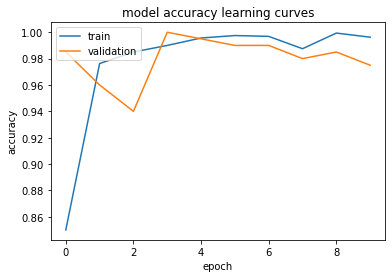

In [7]:
# accuracy curve
pyplot.plot(history.history["accuracy"])
pyplot.plot(history.history["val_accuracy"])
pyplot.title("model accuracy learning curves")
pyplot.ylabel("accuracy")
pyplot.xlabel("epoch")
pyplot.legend(['train', 'validation'], loc="upper left")
pyplot.show()

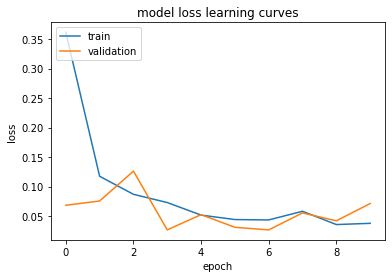

In [8]:
# accuracy curve
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss learning curves')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper left')
pyplot.show()

## Save model

In [9]:
model.save("model_vgg16_v1.h5")

In [12]:
prediction = model.predict(testit) # predict probabilities

In [15]:
y_pred = [int(round(i[0])) for i in prediction] # converting probabilities to binary outputs

## Performance metrics

In [21]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [22]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=pyplot.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, "{:0.2f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

In [23]:
target_names = ["fall armyworm", "healthy"]

In [24]:
print("Confusion Matrix")
conf_matrix = confusion_matrix(testit.classes, y_pred)
print(conf_matrix)

Confusion Matrix
[[344   5]
 [  6 343]]


### Normalized Confusion matrix

Normalized confusion matrix
[[0.98567335 0.01432665]
 [0.01719198 0.98280802]]


<function matplotlib.pyplot.show(close=None, block=None)>

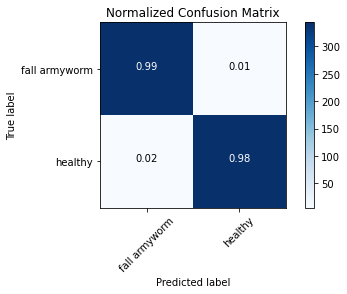

In [25]:
pyplot.figure(0)
plot_confusion_matrix(conf_matrix, classes=target_names, normalize=True, title="Normalized Confusion Matrix")
pyplot.show

### Confusion matrix without normalization

Confusion matrix, without normalization
[[344   5]
 [  6 343]]


<function matplotlib.pyplot.show(close=None, block=None)>

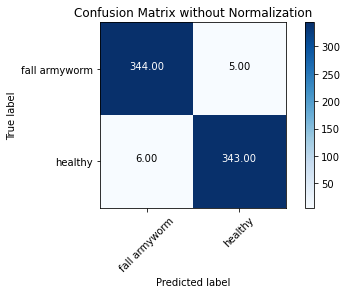

In [27]:
pyplot.figure(1)
plot_confusion_matrix(conf_matrix, classes=target_names, normalize=False, title="Confusion Matrix without Normalization")
pyplot.show

### Classification report

In [29]:
print(classification_report(testit.classes, y_pred, target_names=target_names))

               precision    recall  f1-score   support

fall armyworm       0.98      0.99      0.98       349
      healthy       0.99      0.98      0.98       349

     accuracy                           0.98       698
    macro avg       0.98      0.98      0.98       698
 weighted avg       0.98      0.98      0.98       698

